In [1]:
from GAN_trainer import GAN_Trainer
from GAN_models import *

In [2]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [3]:
generator = Generator64(channels = 1)
discriminator = Discriminator64(channels = 1)
generator.apply(weights_init)
discriminator.apply(weights_init)
generator.cuda()
discriminator.cuda()
print("")

In [4]:
train_data = UCSD(2, image_size = 64, sample_stride=1)

16it [00:02,  7.95it/s]


In [5]:
train_loader, val_loader = get_data_loaders(train_data, batch_size=128)

In [6]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  999


In [7]:
# Root directory for dataset
dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [8]:
device = torch.device("cuda:0")

In [9]:
netD = discriminator
netG = generator

In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
dataloader = train_loader

In [12]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/100][0/18]	Loss_D: 1.7386	Loss_G: 3.1308	D(x): 0.5258	D(G(z)): 0.5907 / 0.0638
[1/100][0/18]	Loss_D: 0.0342	Loss_G: 8.3065	D(x): 0.9976	D(G(z)): 0.0309 / 0.0003
[2/100][0/18]	Loss_D: 0.0089	Loss_G: 8.5761	D(x): 0.9989	D(G(z)): 0.0078 / 0.0002
[3/100][0/18]	Loss_D: 0.0063	Loss_G: 8.7648	D(x): 0.9995	D(G(z)): 0.0058 / 0.0002
[4/100][0/18]	Loss_D: 0.0047	Loss_G: 7.9903	D(x): 0.9994	D(G(z)): 0.0041 / 0.0004
[5/100][0/18]	Loss_D: 0.0038	Loss_G: 8.3839	D(x): 0.9996	D(G(z)): 0.0034 / 0.0003
[6/100][0/18]	Loss_D: 0.0040	Loss_G: 8.5628	D(x): 0.9997	D(G(z)): 0.0036 / 0.0002
[7/100][0/18]	Loss_D: 0.0048	Loss_G: 8.2980	D(x): 0.9996	D(G(z)): 0.0044 / 0.0003
[8/100][0/18]	Loss_D: 0.0034	Loss_G: 8.5008	D(x): 0.9994	D(G(z)): 0.0029 / 0.0002
[9/100][0/18]	Loss_D: 0.0028	Loss_G: 8.1709	D(x): 0.9993	D(G(z)): 0.0021 / 0.0003
[10/100][0/18]	Loss_D: 0.0028	Loss_G: 7.8643	D(x): 0.9996	D(G(z)): 0.0023 / 0.0004
[11/100][0/18]	Loss_D: 0.0034	Loss_G: 8.3599	D(x): 0.9989	D(G(z)): 0.00

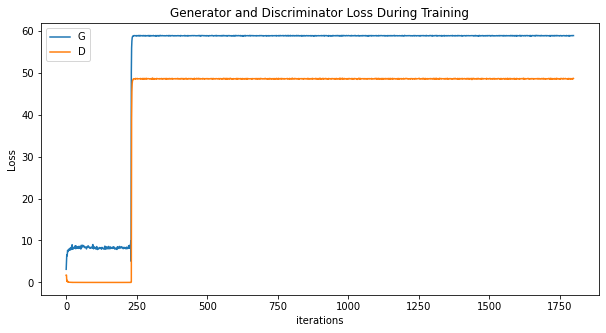

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

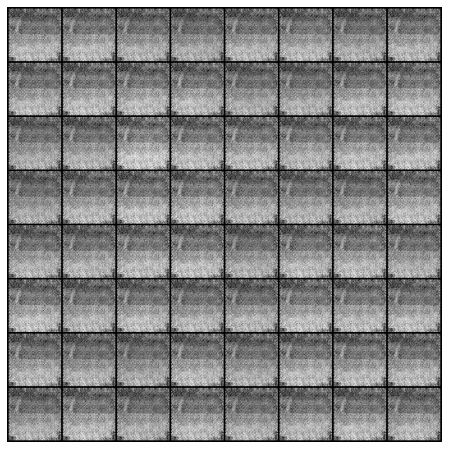

In [14]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

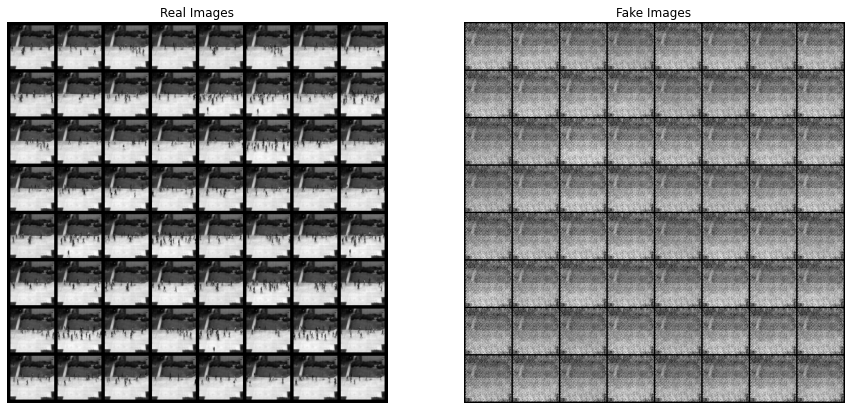

In [15]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
trainer = GAN_Trainer(generator, discriminator)

In [ ]:
trainer.train(train_loader, val_loader, save_path="GAN_models/", epochs = 200, embedding_cube =1)

[1/200]	Loss_D: 0.1171	Loss_G: 0.0493	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000	Time: 0.7 (m)
[2/200]	Loss_D: 0.1008	Loss_G: 0.0504	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000	Time: 0.7 (m)
[3/200]	Loss_D: 0.1006	Loss_G: 0.0503	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000	Time: 0.7 (m)
[4/200]	Loss_D: 0.0993	Loss_G: 0.0503	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000	Time: 0.7 (m)
[5/200]	Loss_D: 0.0996	Loss_G: 0.0498	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000	Time: 0.7 (m)
[6/200]	Loss_D: 0.0999	Loss_G: 0.0501	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000	Time: 0.7 (m)
[7/200]	Loss_D: 0.0998	Loss_G: 0.0502	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000	Time: 0.7 (m)
[8/200]	Loss_D: 0.1000	Loss_G: 0.0503	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000	Time: 0.7 (m)
[9/200]	Loss_D: 0.0997	Loss_G: 0.0495	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000	Time: 0.7 (m)
[10/200]	Loss_D: 0.1003	Loss_G: 0.0497	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000	Time: 0.7 (m)
[11/200]	Loss_D: 0.0998	Loss_G: 0.0499	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000	Time: 0.7 (m)
[12/200]